In [110]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import to_networkx, to_undirected
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import numpy as np
%matplotlib inline

In [66]:
class Net(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        out = F.log_softmax(x, 1)
        return x, out

In [104]:
def plot_network(data, node_labels=None):
    fig, ax = plt.subplots()
    fig.set_tight_layout(False)
    nx_g = to_networkx(data=data).to_undirected()
    pos = nx.kamada_kawai_layout(nx_g)
    if node_labels != None:
        node_color = [[0.5, 0.5, 0.5] if x else [1, 0.5, 0.5] for x in node_labels]
    else:
        node_color = [[0.5, 0.5, 0.5]]
    nx.draw(nx_g, pos, with_labels=True, node_color=node_color)
    plt.show()

## Prepare cora data

In [120]:
edge_file = "cora.cites.txt"
node_file = "cora.content.txt"
# read node attributes
tags = []
node_attrs = []
node_ids = []
with open(node_file, "r") as f:
    for line in f:
        l = line.split("\t")
#         print(len(l))
        node_ids.append(int(l[0]))
        node_attrs.append([int(x) for x in l[1: len(l) - 1]])
        tags.append(l[-1].strip("\n"))
        
# create map for node ids and tags
id_map = dict()
for i, id in enumerate(node_ids):
    id_map[id] = i
    id_reverse_map[i] = id
tag_map = dict()
tag_set = list(set(tags))
for i, tag in enumerate(tag_set):
    tag_map[tag] = i
    tag_reverse_map[i] = tag

In [33]:
# read edges
src_l, dst_l = [], []
with open(edge_file, "r") as f:
    for line in f:
        src = line.split("\t")[0]
        dst = line.split("\t")[1]
        src_l.append(id_map[int(src)])
        dst_l.append(id_map[int(dst)])

In [68]:
# create Data object
edge_index = torch.tensor([src_l, dst_l], dtype=torch.long)
x = torch.tensor(node_attrs, dtype=torch.float)
tag_index = [tag_map[x] for x in tags]
tag_code = torch.tensor(tag_code)
data = Data(x=x, edge_index=edge_index)

## shuffle and split train and test datasets randomly

In [96]:
permutation = np.random.permutation(len(tags))
train_mask, test_mask = permutation[:int(len(tags)*0.3)], permutation[int(len(tags)*0.3) + 1: ]

## train

In [98]:
in_feats, num_class = len(node_attrs[0]), len(tag_map)
hidden_feats = 128
model = Net(in_feats, 128, num_class)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
all_logits = []
for epoch in range(20):
    optimizer.zero_grad()
    logits, out = model(data)
    all_logits.append(logits.detach())
    loss = F.nll_loss(out[train_mask], tag_code[train_mask])
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

/Users/leishi/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch 0 | Loss: 1.9442
Epoch 1 | Loss: 1.7461
Epoch 2 | Loss: 1.4983
Epoch 3 | Loss: 1.2549
Epoch 4 | Loss: 1.0122
Epoch 5 | Loss: 0.7731
Epoch 6 | Loss: 0.5853
Epoch 7 | Loss: 0.4503
Epoch 8 | Loss: 0.3508
Epoch 9 | Loss: 0.2793
Epoch 10 | Loss: 0.2315
Epoch 11 | Loss: 0.1979
Epoch 12 | Loss: 0.1691
Epoch 13 | Loss: 0.1427
Epoch 14 | Loss: 0.1214
Epoch 15 | Loss: 0.1059
Epoch 16 | Loss: 0.0935
Epoch 17 | Loss: 0.0814
Epoch 18 | Loss: 0.0700
Epoch 19 | Loss: 0.0610


## Validate

In [99]:
model.eval()
_, out_val = model(data)
pred_index = out_val[test_mask].argmax(1)
gt_index = tag_code[test_mask]

In [102]:
# accuracy on test dataset
accuracy_score(gt_index, pred_index)

0.8306068601583113

In [107]:
# balanced accuracy on test dataset
balanced_accuracy_score(gt_index, pred_index)

0.8173240936613039

[[483   0  37  22   6   8  19]
 [  6 102  10  14   0   0   3]
 [ 27  12 168  16   4   8  15]
 [  4   6  10 172   1   4   2]
 [  7   1   4   7 113  12   3]
 [  4   0   4   6   1 277   0]
 [ 18   1  13   2   4   0 259]]


Text(30.5, 0.5, 'true')

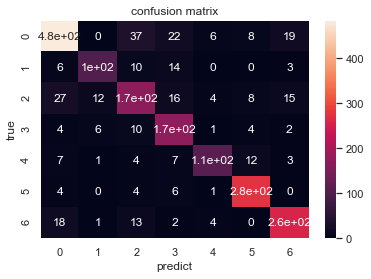

In [119]:
cm = confusion_matrix(gt_index, pred_index)
print(cm)
# visualize confusion matrix
sns.set()
f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')